In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bitcoin-usd-btc-usd/BTC-USD(2).csv
/kaggle/input/bitcoin-usd-btc-usd/BTC-USD.csv


In [2]:
print('Hello World!\n'*10)

Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!
Hello World!



**Сюда можно как-то гит прикрутить?**

In [3]:
df = pd.read_csv('/kaggle/input/bitcoin-usd-btc-usd/BTC-USD(2).csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3106 entries, 0 to 3105
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3106 non-null   object 
 1   Open       3106 non-null   float64
 2   High       3106 non-null   float64
 3   Low        3106 non-null   float64
 4   Close      3106 non-null   float64
 5   Adj Close  3106 non-null   float64
 6   Volume     3106 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 170.0+ KB


In [5]:
df['Date'] = pd.to_datetime(df['Date'])

In [6]:
df = df.set_index(df['Date']).drop('Date', axis=1)

In [7]:
df = df[['Close', "Volume"]]

<AxesSubplot:xlabel='Date'>

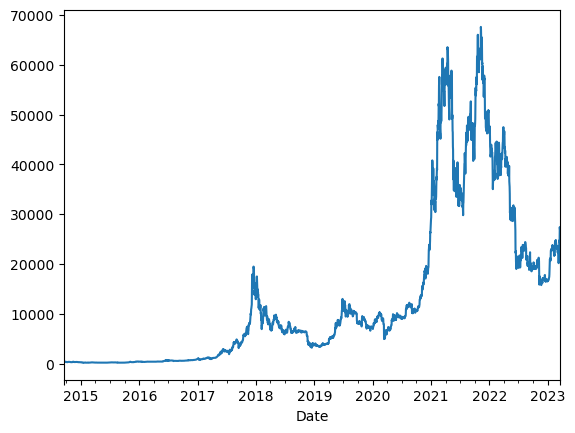

In [8]:
df['Close'].plot(kind='line')

<AxesSubplot:xlabel='Date'>

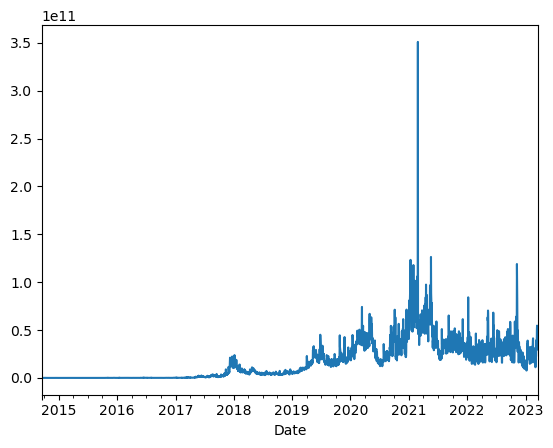

In [9]:
df['Volume'].plot(kind='line')